> ### EEE4423: Deep Learning Lab

# LAB \#6: Semantic Segmentation

<h4><div style="text-align: right"> Due date: April 15, 2022. </div> <br> 
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [Name_ID_lab6.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).


<h2><span style="color:blue">[2019142079] [성재진]</span> </h2>

In [139]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-04-17 08:15:50.994485


In [140]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models




## Introduction


### What is Semantic Segmentation?
#### Semantic segmentation is an approach to understand what is in the image in pixel-level:

- It is a lot more difficult than image classification, which makes a prediction in image-level.

- It differs from object detection in that it has no information about instances.

<img src="https://drive.google.com/uc?export=view&id=1aR-RSJCsSEROjmQych61RbIhBul9cqA1" alt="no_image" style="width: 900px;"/>

Applications for semantic segmentation include:

- Autonomous driving

- Image Editing

- Classification of terrain visible in satellite imagery

- Medical imaging analysis

### 1. Semantic segmentation with CNNs
- Typical classification models (AlexNet, VGGNet, ...) take fixed-sized inputs and produce a probability vector. The fully connected layers of these models have fixed dimensions and throw away spatial coordinates. 


- It is known that the fully connected layer can be viewed as a convolution layer with a kernel that covers only one pixel, that is, a 1x1 kernel. Thus, we can convert the fully connected layers into convolution layers with maintaining pre-trained weights.


- After 'convolutionalizing' fully connected layers, a feature map needs to be upsampled because of pooling operations in the models. Instead of using simple bilinear interpolation, we can use a transposed convolution layer to learn the interpolation process. This layer is also called as upconvolution, deconvolution or fractionally-strided convolution.

### 1.1 Pixel wise classification using sliding window

<img src="https://drive.google.com/uc?export=view&id=1l2-Degy7LpK20NbooHosRV8NzeRvNdPd" alt="no_image" style="width: 900px;"/>

### 1.1.1 Example with VGG-Net

**Load a test image**

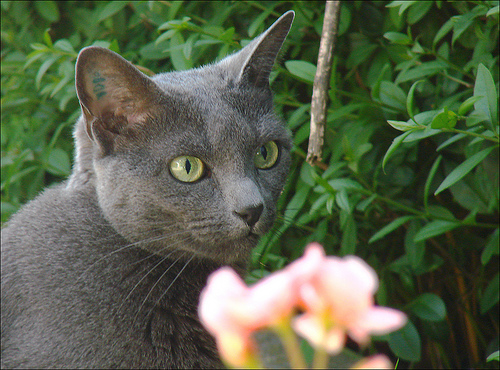

In [141]:
from PIL import Image
test_img_path = './dataset-dllab/lab06/img/2009_005160.jpg'
test_img = Image.open(test_img_path)
test_img

**Standardization of the test image**

In [142]:
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

test_transform = transform(test_img).cuda().unsqueeze(0)
print(test_transform.size())

torch.Size([1, 3, 224, 224])


**Load VGG-Net**

In [143]:
import torchvision.models.vgg as vgg
imageNet = vgg.vgg16(pretrained=True).cuda()

In [144]:
import torch
import torch.nn as nn
with torch.no_grad():
    out = imageNet(test_transform)

out_class = torch.argmax(out)
print(out.size())
print(out_class) # 285 is egyptian cat in ImageNet

torch.Size([1, 1000])
tensor(285, device='cuda:0')


In [145]:
# padding
m = nn.ZeroPad2d((111,112,111,112))
pad_image = m(test_transform)
res = torch.zeros((224,224)).cuda()

In [146]:
# sliding window approach for segmentation
# NOTICE: It takes some time
for i in range(224):
    for j in range(224):
        patch = pad_image[:,:,i:i+224,j:j+224]
        # classify each pixels
        with torch.no_grad():
            res[i,j] = torch.argmax(imageNet(patch))

In [147]:
print(res)

tensor([[285., 285., 285.,  ..., 285., 285.,  24.],
        [285., 285., 285.,  ..., 285., 285., 285.],
        [285., 285., 285.,  ..., 285.,  24., 282.],
        ...,
        [284., 360., 150.,  ..., 299., 254., 254.],
        [284., 286., 285.,  ..., 299., 254., 254.],
        [286., 285., 286.,  ..., 254., 254., 254.]], device='cuda:0')


In [148]:
print(res.size())

torch.Size([224, 224])


**Visualize the output, classified as 'egyptian cat' (285)**

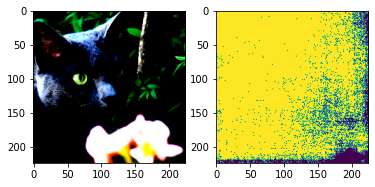

In [149]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(test_transform[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow((res==285).data.cpu().numpy()) # Visualize pixels classified as egyptian cat
plt.show()

- Inefficient & Ineffective !

### 1.2 Pixel wise classification using image classification

<img src="https://drive.google.com/uc?export=view&id=1sWibO6xfau_kfWt-2T_rh_ARrzsR4PRV" alt="no_image" style="width: 900px;"/>

#### 1.2.1 Convolutional VGG

In [150]:
import torchvision.models as models

class ConvolutionalVGG(nn.Module):
    def __init__(self):
        super(ConvolutionalVGG, self).__init__()
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        # fc8
        self.fc8 = nn.Conv2d(4096, 1000, 1)
        
        self.copy_params_from_vgg16()

    def forward(self, x):
        conv5 = self.features(x)
        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)
        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)
        score = self.fc8(fc8)
        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3, 6], ['fc6', 'fc7', 'fc8']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [151]:
conv_vgg = ConvolutionalVGG().cuda()
conv_vgg

ConvolutionalVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [152]:
transform_conv = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

In [153]:
test_conv = transform_conv(test_img).cuda().unsqueeze(0)
print(test_conv.size())

torch.Size([1, 3, 370, 500])


In [154]:
conv_out = conv_vgg(test_conv)
pred = torch.argmax(conv_out, dim=1)
pred

tensor([[[285, 285, 284, 284, 284, 285, 285, 285, 285],
         [284, 284, 284, 284, 284, 285, 285, 285, 285],
         [285, 285, 284, 284, 285, 285, 285, 285, 285],
         [285, 285, 285, 285, 285, 284, 284, 285, 285],
         [285, 285, 285, 285, 285, 285, 285, 285, 285]]], device='cuda:0')

Well...

Although modifying VGG-Net to fully convolutional network results in a pixel-wise ouput, the output resolution is smaller than the original image resolution. Moreover, we can see that many pixels are misclassified (i.e., not 285).

#### 1.2.2 Add simple upsampling layer (Bilinear) and retrain with PASCAL VOC 2012  [1 point]
- Re-define the last layer so as to classify classes in the PASCAL VOC datasets
- Use bilinear interpolation to make the network output equal to the input size

In [162]:
import torchvision.models as models

class ConvolutionalVGGwithUpsample(nn.Module):
    def __init__(self):
        super(ConvolutionalVGGwithUpsample, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.features[0].padding = (100,100)
        
        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        # fc8
        #############
        self.fc8 = nn.Conv2d(4096, 21, 1) #class가 21개이므로 output channel을 21로 설정
        #############
        
        
        self.copy_params_from_vgg16()
        

    def forward(self, x):
        conv5 = self.features(x)
        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)
        
        #fc7 = self.relu7(self.fc7(fc7))
        #fc8 = self.drop7(fc7)
        
        score = self.fc8(fc7)
        
        
        #############
        #원래 이미지 size로 bilinear하게 upsamplng해준다.
        score=nn.functional.interpolate(score, size=x.size()[2:], scale_factor=None, mode='bilinear', align_corners=None)
        #############
                
        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [163]:
conv_vgg_upsample = ConvolutionalVGGwithUpsample().cuda()

In [164]:
def decode_labels(mask, num_classes=21):
    from PIL import Image         
    label_colours = [(0, 0, 0)
                 # 0=background
                 , (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128)
                 # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                 , (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0)
                 # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                 , (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128)
                 # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                 , (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]
                 # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
        
    h, w = mask.shape

    img = Image.new('RGB', (w, h))
    pixels = img.load()
    for j_, j in enumerate(mask[:, :]):
        for k_, k in enumerate(j):
            if k < num_classes:
                pixels[k_, j_] = label_colours[k]
    output = np.array(img)

    return output

In [165]:
model_data = torch.load('./pretrain/lab06/vgg_conv_upsample.pth')
conv_vgg_upsample.load_state_dict(model_data)

<All keys matched successfully>

In [166]:
with torch.no_grad():
    conv_out = conv_vgg_upsample(test_conv)
output = torch.argmax(conv_out, dim=1)

vis_output = decode_labels(output[0].data.cpu().numpy())

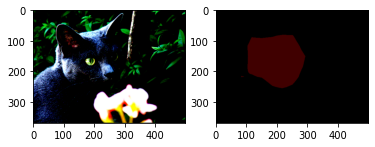

In [167]:
plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)

### 1.3 Upsampling method with CNNs

#### 1.3.1 Transposed Convolution

<img src="https://drive.google.com/uc?export=view&id=1IfoOAei35ydfeWu5qlXhZwNnW8cy_tJn"  onerror="this.style.display='none'" /><br><br>


- The transposed convolution (it is often called as "deconvolution") is used to up-sample the input resolution by using learnable filters. In contrast to the standard convolution, which aggregates spatial information to a single point, it spreads a point of the input over multiple spatial locations.
- For example, a $3\times3$ kernel with a stride of 2 converts the~$2\times2$~(cyan squares) input into the~$5\times5$~(blue squares) output.

#### 1.3.2 Dilated Convolution
<img src="https://drive.google.com/uc?export=view&id=1DCDuj_6IhA8HdZzE8OZkrYIuDeevtjKV"  onerror="this.style.display='none'" /><br><br>

- The dilated convolution introduces 'a dilation rate' to the standard convolution.

- The dilation rate means a spacing value between elements of a kernel, which enlarges the receptive field without introducing additional parameters.

- For example, a $3\times3$ kernel with a dilation rate of 2 has the same receptive field as a $5\times5$ kernel while it still use 9 parameters only, compared to the $5\times5$ the uses 25 parameters. 

## 2. [Lab] Semantic segmentation 

### 2.1 Write a FCN8s model  [4 points]

<img src="https://drive.google.com/uc?export=view&id=1icsmWH1-N_g90VJOg7zyIFVec-TmPscA"  onerror="this.style.display='none'" /><br><br>

<p style='text-align:right;'>[<a href='https://medium.com/@wilburdes/semantic-segmentation-using-fully-convolutional-neural-networks-86e45336f99b'>source</a>]</p>

**Crop boundary example**

In [177]:
a = torch.ones((1, 1, 160, 140))
b = torch.ones((1, 1, 120, 120))

try:
    a + b
except:
    print('The size of tensors are different')
    print(a.size())
    print(b.size())
    
# crop boundary 
a = a[:, :, 5: 5+b.size(2), 5:5+b.size(3)]

# add connection with weight
c = 0.01*a + b 

The size of tensors are different
torch.Size([1, 1, 160, 140])
torch.Size([1, 1, 120, 120])


- Predict 1: $1\times1$ Conv(in: 4096, out: n_class)
- Predict 2: $1\times1$ Conv(in: 512, out: n_class), weight = 0.01
- Predict 3: $1\times1$ Conv(in: 256, out: n_class), weight = 0.0001

- Deconv 1: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 2: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 3: $16\times16$ Transposed Conv (in: n_class, out: n_class, stride: 8, biase: False)

In [206]:
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # VGG features
        self.features = models.vgg16(pretrained=True).features
        
        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        #############
        #주어진 조건에 따라 layer를 설정한다.
        #Predict1
        self.Predict1 = nn.Conv2d(in_channels=4096, out_channels=n_class, kernel_size=1, stride=1)
        
        #Predict2
        self.Predict2 = nn.Conv2d(in_channels=512, out_channels=n_class, kernel_size=1, stride=1)
        nn.init.constant_(self.Predict2.weight,0.01)
        
        #Predict3
        self.Predict3 = nn.Conv2d(in_channels=256, out_channels=n_class, kernel_size=1, stride=1)
        nn.init.constant_(self.Predict3.weight,0.0001)
        
        #Deconv1
        self.Deconv1 = nn.ConvTranspose2d(in_channels=n_class, out_channels=n_class, kernel_size=4, stride=2, bias=False)
        
        #Deconv2
        self.Deconv2 = nn.ConvTranspose2d(in_channels=n_class, out_channels=n_class, kernel_size=4, stride=2, bias=False)
        
        #Deconv3
        self.Deconv3 = nn.ConvTranspose2d(in_channels=n_class, out_channels=n_class, kernel_size=16, stride=8, bias=False)
        ############# 
        
        
        
        self._initialize_weights()
        self.copy_params_from_vgg16()

    def _initialize_weights(self):
        self.features[0].padding = (100,100)
        
        for m in self.modules():
            if isinstance(m, nn.MaxPool2d):
                m.ceil_mode=True
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        #############
       
        og_size=x.size()
        
        #Pool3과 Pool4의 features를 저장하기 위해 MaxPool2d layer의 features를 저장
        Pool_features = []
        for layer in self.features:
            x = layer(x)
            if isinstance(layer, nn.MaxPool2d):
                Pool_features.append(x)

        fc6 = self.relu6(self.fc6(x))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)

        Predict1 = self.Predict1(fc8)
        Deconv1 = self.Deconv1(Predict1)
        
        Predict2 = self.Predict2(Pool_features[3])#Pool4
        #boundary를 crop해야 하는데 size에 따라 feature map의 가운데 부분을 제외하고 crop한다.
        diff1=(Predict2.size(2)-Deconv1.size(2))//2
        Predict2 = Predict2[:, :, diff1: diff1 + Deconv1.size(2), diff1: diff1 + Deconv1.size(3)]#crop boundary 하여 deconv를 통과한 map과 size를 맞춰준다.

        Summation1 = Deconv1 + Predict2
        Deconv2 = self.Deconv2(Summation1)

        Predict3 = self.Predict3(Pool_features[2])#Pool3
        #boundary를 crop해야 하는데 size에 따라 feature map의 가운데 부분을 제외하고 crop한다.
        diff2=(Predict3.size(2)-Deconv2.size(2))//2
        Predict3 = Predict3[:, :, diff2: diff2 + Deconv2.size(2), diff2: diff2 + Deconv2.size(3)]#crop boundary 하여 deconv를 통과한 map과 size를 맞춰준다.

        Summation2 = Deconv2 +  Predict3
        Deconv3 = self.Deconv3(Summation2)
        #boundary를 crop해야 하는데 size에 따라 feature map의 가운데 부분을 제외하고 crop한다.
        diff3=(Deconv3.size(2)-og_size[2])//2
        Deconv3 = Deconv3[:, :, diff3: diff3 + og_size[2], diff3: diff3 + og_size[3]]#crop boundary 하여 원래 이미지와 size를 맞춰준다.
        x = Deconv3
        ############# 
        
        
        return x

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))
            
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [207]:
model = FCN8s().cuda()

**Data Loader functions**

In [208]:
import random
import os

def read_file(path_to_file):
    with open(path_to_file) as f:
        img_list = []
        for line in f:
            img_list.append(line[:-1])
    return img_list

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def flip(I, flip_p):
    if flip_p > 0.5:
        return np.fliplr(I)
    else:
        return I

def scale_im(img_temp, scale):
    new_dims = (int(img_temp.shape[0] * scale), int(img_temp.shape[1] * scale))
    return cv2.resize(img_temp, new_dims).astype(float)


def get_data(chunk, gt_path='./dataset-dllab/lab06/gt', img_path='./dataset-dllab/lab06/img'):
    assert len(chunk) == 1

    scale = random.uniform(0.5, 1.3)
    flip_p = random.uniform(0, 1)

    images = cv2.imread(os.path.join(img_path, chunk[0] + '.jpg')).astype(float)

    images = cv2.resize(images, (321, 321)).astype(float)
    images = scale_im(images, scale)
    images[:, :, 0] = images[:, :, 0] - 104.008
    images[:, :, 1] = images[:, :, 1] - 116.669
    images[:, :, 2] = images[:, :, 2] - 122.675
    images = flip(images, flip_p)
    images = images[:, :, :, np.newaxis]
    images = images.transpose((3, 2, 0, 1))
    images = torch.from_numpy(images.copy()).float()

    gt = cv2.imread(os.path.join(gt_path, chunk[0] + '.png'))[:, :, 0]
    gt[gt == 255] = 0
    gt = flip(gt, flip_p)

    dim = int(321 * scale)

    gt = cv2.resize(gt, (dim, dim), interpolation=cv2.INTER_NEAREST).astype(float)
    
    labels = gt[np.newaxis, :].copy()

    return images, labels

**Data load**

In [209]:
img_list = read_file('./dataset-dllab/lab06/list/train_aug.txt')
data_list = []

for i in range(10):
    np.random.shuffle(img_list)
    data_list.extend(img_list)
data_gen = chunker(data_list, 1)

In [211]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [212]:
lr = 1e-5   # choose your lr

optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.zero_grad()
max_iter = 25000

### 2.2 Write train code and print loss [2 points]
- Use a cross-entropy loss.
- Print a training loss for every 100 iterations.
- Show that the training loss steadily decreases.

In [213]:
criterion=nn.CrossEntropyLoss().to(device)

def loss_calc(out, label):
    #############
    #print(out.size())
    #print(label.size())
    label=label.long()
    return criterion(out,label)
    ############# 
    

In [214]:
running_loss = 0.0

for iter in range(max_iter + 1):
    inputs, label = get_data(next(data_gen))
    
    #############
    model.train()
    inputs=inputs.to(device)
    label=torch.from_numpy(label).to(device)
    
    # gradient 값 0으로 초기화
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Loss 계산: cross entropy loss
    loss = loss_calc(outputs, label)

    # back propagation을 통해 gradient 계산
    loss.backward()

    running_loss += loss.item()

    # parameters 업데이트
    optimizer.step()
    
    if(iter+1)%100 ==0:
        print("iteration: {}, Loss: {}".format(iter+1,running_loss/100))
        running_loss=0.0
    ############# 
        
        

iteration: 100, Loss: 2.903361326083541
iteration: 200, Loss: 1.8613833212852477
iteration: 300, Loss: 1.6275224609673022
iteration: 400, Loss: 1.4889864145219327
iteration: 500, Loss: 1.2671581426262855
iteration: 600, Loss: 1.2058155738189817
iteration: 700, Loss: 1.1278305687010288
iteration: 800, Loss: 1.1177961491793393
iteration: 900, Loss: 1.0168202798813581
iteration: 1000, Loss: 1.1169177452661097
iteration: 1100, Loss: 1.0015340566635131
iteration: 1200, Loss: 1.0713493028283119
iteration: 1300, Loss: 1.0019011368602515
iteration: 1400, Loss: 0.9620877339690924
iteration: 1500, Loss: 1.0188111696392297
iteration: 1600, Loss: 0.9043187857791781
iteration: 1700, Loss: 0.9320338719338178
iteration: 1800, Loss: 0.9460078290104866
iteration: 1900, Loss: 0.9304925378039479
iteration: 2000, Loss: 0.7976882527768612
iteration: 2100, Loss: 0.9322079385817051
iteration: 2200, Loss: 0.883021769989282
iteration: 2300, Loss: 0.8426083064824342
iteration: 2400, Loss: 0.8152937738597393
ite

### 2.3 Discuss the result [3 points]
- Compare and Discuss the results. Note that it must contain the quantitative and qualitative results.
- Use the below 'validation_miou' function to evaluate your model. Your model should perform better than the example model **(0.47 mIoU)**.
- Use the above 'decode_label' function to visualize the network output.

In [215]:
def validation_miou(model):
    max_label = 20
    hist = np.zeros((max_label + 1, max_label + 1))
    
    def fast_hist(a, b, n):
        k = (a >= 0) & (a < n)
        return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)
    
    val_list = open('./dataset-dllab/lab06/list/val.txt').readlines()
    
    with torch.no_grad():
        for idx, i in enumerate(val_list):
            print('{}/{} ...'.format(idx + 1, len(val_list)))

            img = cv2.imread(os.path.join('./dataset-dllab/lab06/img', i[:-1] + '.jpg')).astype(float)

            img[:, :, 0] -= 104.008
            img[:, :, 1] -= 116.669
            img[:, :, 2] -= 122.675

            data = torch.from_numpy(img.transpose((2,0,1))).float().cuda().unsqueeze(0)
            score = model(data)

            output = score.cpu().data[0].numpy().transpose(1, 2, 0)
            output = np.argmax(output, axis=2)
            gt = cv2.imread(os.path.join('./dataset-dllab/lab06/gt', i[:-1] + '.png'), 0)

            hist += fast_hist(gt.flatten(), output.flatten(), max_label + 1)

        miou = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
        print("Mean iou = ", np.sum(miou) / len(miou))
        
    return np.sum(miou) / len(miou)

In [216]:
#############
# CODE HERE #
############# 

#mIoU of model
fcn8s_miou=validation_miou(model)

#mIoU of model in section 1.2.2
bilinearVgg_miou=validation_miou(conv_vgg_upsample)

1/1449 ...
2/1449 ...
3/1449 ...
4/1449 ...
5/1449 ...
6/1449 ...
7/1449 ...
8/1449 ...
9/1449 ...
10/1449 ...
11/1449 ...
12/1449 ...
13/1449 ...
14/1449 ...
15/1449 ...
16/1449 ...
17/1449 ...
18/1449 ...
19/1449 ...
20/1449 ...
21/1449 ...
22/1449 ...
23/1449 ...
24/1449 ...
25/1449 ...
26/1449 ...
27/1449 ...
28/1449 ...
29/1449 ...
30/1449 ...
31/1449 ...
32/1449 ...
33/1449 ...
34/1449 ...
35/1449 ...
36/1449 ...
37/1449 ...
38/1449 ...
39/1449 ...
40/1449 ...
41/1449 ...
42/1449 ...
43/1449 ...
44/1449 ...
45/1449 ...
46/1449 ...
47/1449 ...
48/1449 ...
49/1449 ...
50/1449 ...
51/1449 ...
52/1449 ...
53/1449 ...
54/1449 ...
55/1449 ...
56/1449 ...
57/1449 ...
58/1449 ...
59/1449 ...
60/1449 ...
61/1449 ...
62/1449 ...
63/1449 ...
64/1449 ...
65/1449 ...
66/1449 ...
67/1449 ...
68/1449 ...
69/1449 ...
70/1449 ...
71/1449 ...
72/1449 ...
73/1449 ...
74/1449 ...
75/1449 ...
76/1449 ...
77/1449 ...
78/1449 ...
79/1449 ...
80/1449 ...
81/1449 ...
82/1449 ...
83/1449 ...
84/1449 ...
8

In [217]:
print('Mean IoU of model FCN-8s is:', fcn8s_miou)
print('Mean IoU of model bilinear upsampled VGG-16 is:', bilinearVgg_miou)

Mean IoU of model FCN-8s is: 0.49886299262274597
Mean IoU of model bilinear upsampled VGG-16 is: 0.4433510859503631


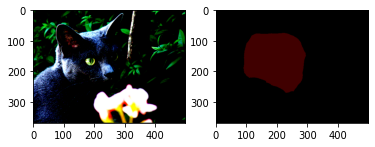

In [218]:
# Visualize the result
#############
with torch.no_grad():
    conv_out = model(test_conv)
    
output = torch.argmax(conv_out, dim=1)

vis_output = decode_labels(output[0].data.cpu().numpy())

plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)
############# 


### *References*
[1] FCN official code (https://github.com/shelhamer/fcn.berkeleyvision.org)

[2] Upsampling method (https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

[3] Cs231n (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)

### *Discussion*

결과를 살펴보면, FCN-8s의 mIOU는 0.49886299262274597 이고 bilinear upsampled VGG-16의 mIOU는 0.4433510859503631로 bilinear upsampled보다 FCN-8s의 mIOU가 월등하게 더 높은 것을 확인할 수 있다. 이는 시각적으로 확인해보았을때는 무엇이 segmentation을 더 잘했는지 확인하기는 어렵지만 ground-truth와 pixel by pixel 비교해보았을 때 segmentation의 결과가 FCN-8s가 더 정확하다는 것이다.
FCN-8s model은 skip connection을 사용하는데 이는 다양한 level의 feature information을 결합하여 성능을 높인다. bilinear upsampling 대신 deconvolution을 사용하는데, 이는 비선형성을 가지고 있고 학습이 가능하기 때문에 더 정교한 upsampling 결과를 생성한다.

이번 실험에서 skip connection을 사용할 때 feature map끼리의 크기를 맞춰야 함으로 boundary를 crop해줘야 했는데 상하좌우로 얼마만큼 crop해줘야 하는지 조건이 주어져 있지 않았다. 또한, 임의의 숫자만큼 crop을 해주는 걸로 정해주자니, image마다 size가 다르기 때문에 어떤 이미지의 feature map은 가운데 부분을 남기게 되지만 어떤 이미지는 한쪽으로 치우친 부분으로 남기게 된다. 따라서 일관성있게 crop해주기 위해, feature map의 가운데를 남기고 crop하도록 하였다.
또한, 기본적으로 설정된 max iteration은 20000이었지만, max iteration이 25000이었을 때가 mIOU가 훨씬 높게 나와 max iteration을 25000으로 설정했다.